In [2]:
import multiSyncPy as msp
from sktime.utils.plotting import plot_correlations
from multiSyncPy import synchrony_metrics as sm
from scipy.signal import hilbert
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
from multisync_functions import get_multisync_metrics, get_multisync_statistics
from IPython.display import display

ant_colonies = get_ant_datafiles_info()

In [3]:

# take a single "trial" (one group of ants moving through time and space) as an example
example_data = ant_colonies['file'][0]
ants = preprocess_antcolony_data(example_data)

# this one has the ant_id as the index
ant_dict = {ant_id: ants[ants['ant_id'] == ant_id] for ant_id in ants['ant_id'].unique()}

print(f"Number of unique ants: {ants['ant_id'].nunique()}")

Number of unique ants: 10


In [4]:
# a starting approach can be to investigate one single ant only:
# ant_11 = ant_dict[11]
# plot_correlations(ant_11['x'])
# plt.show()

Coherence: 0.14483338190959055
Symbolic entropy: 4.127137193429166
Rho: 0.9801752887280589


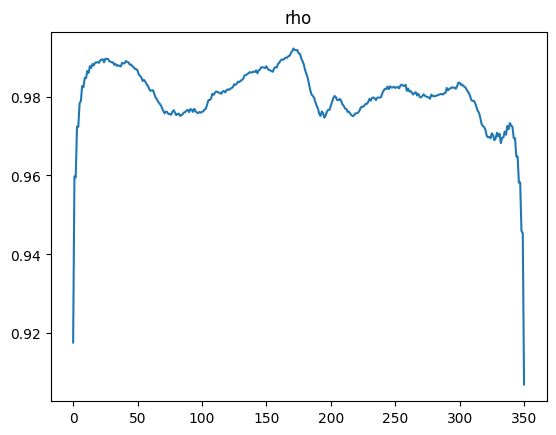

In [5]:
# try "multivariate synchrony" approaches
ant_team_data = np.array([ant_data['x'].values for ant_data in ant_dict.values()])
data_phases = np.angle(hilbert(ant_team_data))

print(f"Coherence: {sm.coherence_team(ant_team_data)}")
print(f"Symbolic entropy: {sm.symbolic_entropy(ant_team_data)}")
print(f"Rho: {sm.rho(data_phases)[1]}")

plt.plot(sm.rho(data_phases)[0])
plt.title('rho')
plt.show()

Ant group investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (inside ant groups vs outside ant groups)

In [6]:
# get all metrics for all ant colonies on a certain target variable (ant x or y position) and compare indoor and outdoor ants
metrics = [get_multisync_metrics(preprocess_antcolony_data(colony), target_var='x', n_observations_per_unit=100, id_column='ant_id') for colony in ant_colonies['file'].tolist()]
coherence, symbolic_entropy, rho = zip(*metrics)

ant_colonies['coherence'] = coherence
ant_colonies['symbolic_entropy'] = symbolic_entropy
ant_colonies['rho'] = rho

display(ant_colonies.head(10))

indoor = ant_colonies[ant_colonies['recording_location'] == 'indoor']
outdoor = ant_colonies[ant_colonies['recording_location'] == 'outdoor']

# by adding the coherence measurements for each ant group, we can compare indoor and outdoor ants
results = get_multisync_statistics(indoor, outdoor)
display(results)


Removed 29 out of 73 units with less than 100 observations
Removed 84 out of 162 units with less than 100 observations
Removed 96 out of 133 units with less than 100 observations
Removed 78 out of 193 units with less than 100 observations
Removed 24 out of 101 units with less than 100 observations


,recording_location,file,coherence,symbolic_entropy,rho
0,indoor,dataset/ants/IndoorDataset/Seq0001Object10Imag...,0.166548,3.614594,0.993421
1,indoor,dataset/ants/IndoorDataset/Seq0002Object10Imag...,0.182019,4.041930,0.996240
2,indoor,dataset/ants/IndoorDataset/Seq0003Object10Imag...,0.180239,4.358343,0.992953
3,indoor,dataset/ants/IndoorDataset/Seq0004Object10Imag...,0.173449,4.270625,0.996883
4,indoor,dataset/ants/IndoorDataset/Seq0005Object10Imag...,0.193218,4.419719,0.999480
5,outdoor,dataset/ants/OutdoorDataset/Seq0006Object21Ima...,0.174629,4.563581,0.945801
6,outdoor,dataset/ants/OutdoorDataset/Seq0007Object26Ima...,0.173496,4.605170,0.985620
7,outdoor,dataset/ants/OutdoorDataset/Seq0008Object31Ima...,0.169954,4.530623,0.957288
8,outdoor,dataset/ants/OutdoorDataset/Seq0009Object50Ima...,0.177439,4.605170,0.956648
9,outdoor,dataset/ants/OutdoorDataset/Seq0010Object30Ima...,0.213477,4.245605,0.896432


,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,0.775554,-0.294932,1.000000,13.0
1,symbolic_entropy,0.051389,-2.288455,0.059327,3.0
2,rho,0.011751,3.247151,0.007937,25.0


Bird flocking investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (not grouped birds vs grouped birds)

In [11]:
from data_functions import process_bird_data
from os.path import isfile
import zipfile

if not isfile('dataset/birds/birds_grouped.csv'):
    with zipfile.ZipFile('dataset/birds/birds_grouped.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/birds')

birds = pd.read_csv('dataset/birds/birds_grouped.csv')
birds_processed_0 = process_bird_data(birds, selected_class=0, target_col_pre='x')
birds_processed_1 = process_bird_data(birds, selected_class=1, target_col_pre='x')

total = max(len(birds_processed_0), len(birds_processed_1))
birds_processed = birds_processed_0[:total] + birds_processed_1[:total]
    
birds_processed = pd.DataFrame(birds_processed, columns=['scene', 'class', 'coherence', 'symbolic_entropy', 'rho'])
display(birds_processed)

ungrouped = birds_processed[birds_processed['class'] == 0]
grouped = birds_processed[birds_processed['class'] == 1]

results = get_multisync_statistics(ungrouped, grouped)
display(results)

,scene,class,coherence,symbolic_entropy,rho
0,0,0,0.179624,5.043566,0.246256
1,1,0,0.183185,4.689891,0.319813
2,2,0,0.179688,4.778566,0.321288
3,3,0,0.175689,4.637633,0.244672
4,4,0,0.176064,4.574029,0.246588
5,5,0,0.181382,4.568310,0.234800
6,6,0,0.176437,4.696244,0.252569
7,7,0,0.176910,4.720687,0.242254
8,8,0,0.180865,4.736153,0.198863
9,9,0,0.183717,4.683235,0.284099


,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,5.776525e-10,-11.899627,0.000183,0.0
1,symbolic_entropy,4.319427e-03,3.263046,0.000769,95.0
2,rho,2.092336e-13,-19.119548,0.000183,0.0
